<a href="https://colab.research.google.com/github/matsonah/ClarkeStatsSpring2022/blob/main/Module_7_Two_Averages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 7 includes stones 46 and 47. 

For those reading the OER text, we are in [Chapter 8](https://openstax.org/books/introductory-statistics/pages/8-introduction). 

Code Block 1 prepares data. You want two data sets when you are done. 

Code Block 2 uses a formula to build a confidence interval. 

Code Block 3 uses a bootstrapping to build a confidence interval and provides a visualization. 

In [3]:
#### Code Block 1 
# Prepare data for analysis 

ethnicity <- read.csv(url("https://raw.githubusercontent.com/matsonah/ClarkeStatsSpring2022/main/data/rae.csv"))

hispanic_sums <- 0
tom_sums <- 0 

years=seq(2013, 2019, 1)
for(year in 1:7) {
  temp_data = subset(ethnicity, ID.Ethnicity==1 & Year==years[year])
  hispanic_sums[year]=sum(temp_data$Population)
  temp_data <- 0 
  temp_data = subset(ethnicity, ID.Race==6 & Year==years[year])
  tom_sums[year]=sum(temp_data$Population)
}

hispanic <- data.frame(Year=years, Population=hispanic_sums)
tom <- data.frame(Year=years, Population=tom_sums)

In [15]:
### Code Block 2
# now that the data are prepared, we can analyze them. 
# IF your sample is big enough (say, 30 or more), you can use this formula. 
# IF your sample is small (say under 30), use Code Block 3. 

data_1 = hispanic$Population
data_2 = tom$Population
conf.level = 0.90


# prepare essential parts from data set 1
x.bar1 = mean(data_1)
size1 = length(data_1)
stdev1 = sd(data_1)
size1l = size1-1

# prepare essential parts from data set 2
x.bar2 = mean(data_2)
size2 = length(data_2)
stdev2 = sd(data_2)
size2l = size2-1 

# Working on figuring out the smaller than 30 sample size scenario
degf = size1l + size2l
t.star = qt ((1-conf.level)/2, df = degf, lower.tail=F)
# build the confidence interval using a formula
comp = x.bar1 - x.bar2

z.star = qnorm(conf.level)
S_p = sqrt((size1l*size1^2 + size2l*size2^2)/(size1l+size2l))
SE = S_p*sqrt(1/size1 + 1/size2)
MoE = abs(z.star) * SE   #z.star for sample sizes around 30+ 
lower = comp - MoE 
upper = comp + MoE 

cat(sep="","At a confidence level of ", conf.level*100, "%, the actual average", 
          " \ndifference in populations is between ", floor(lower)," and ", ceiling(upper), " \npeople.\n\n", 
          "At a confidence level of ", conf.level*100, "%, the actual average", 
          " \ndifference in populations is approximately ", comp, " \nwith an assumed margin of error of ", MoE, ".")


At a confidence level of 90%, the actual average 
difference in populations is between -285 and -274 
people.

At a confidence level of 90%, the actual average 
difference in populations is approximately -279.7143 
with an assumed margin of error of 4.795127.

Bootstrap via repeated sampling with replacement.


With a confidence level of 90%, the actual population paramater is 
between -609.4096 and 49.22955.
At a confidence level of 90%, the actual population parameter is 
approximately -280.09 with a margin of error of 329.3196.


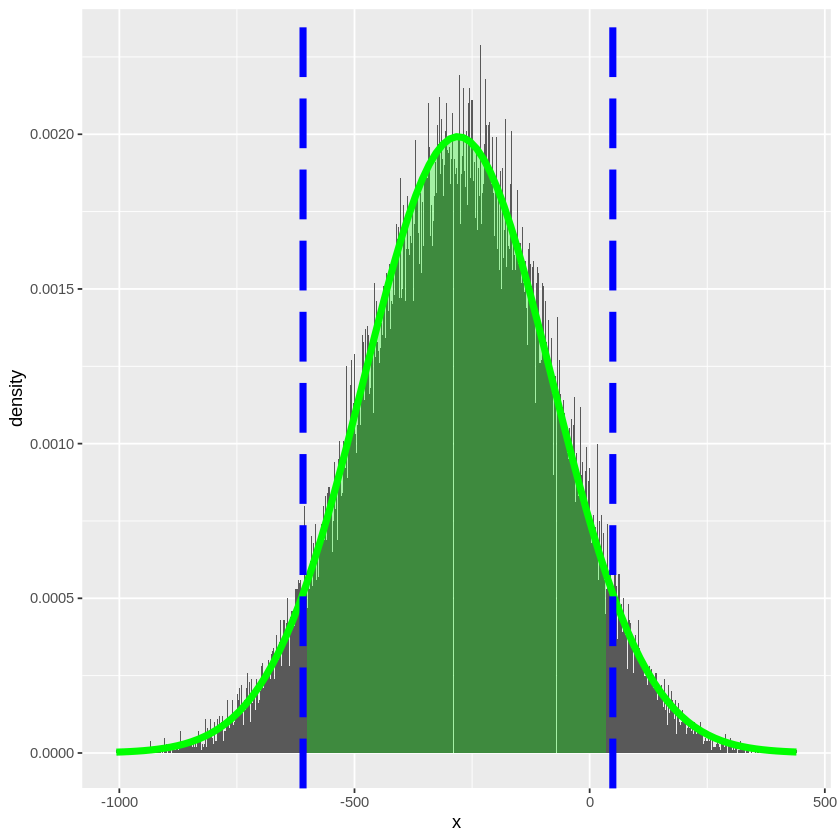

In [8]:
#### Code Block 3 
# fakes drawing samples from a big population based on the hopefully 
# representative samples that were provided. 

z_conf=0.9 

data_1 = hispanic$Population
data_2 = tom$Population


alpha = 1-z_conf 
zsc=qnorm(z_conf + alpha/2)


# creates a bootstrap function called bs. 
bs = function (data1, data2, test_runs){
  size1=length(data1)
  size2=length(data2)
  test <- 0
  for(i in 1:test_runs){ 
    test[i] = mean(sample(data1, size1, replace=TRUE))-mean(sample(data2, size2, replace=TRUE))  #can switch mean out with median
  }
  return(test)
}

Boot = data.frame(x=bs(data_1, data_2,100000))  #calls the bs function for the two data sets. 
Boot_mean = mean(Boot$x)
Boot_sd = sd(Boot$x)
Boot_left=Boot_mean - zsc*Boot_sd
Boot_right=Boot_mean + zsc*Boot_sd 
Boots=c(Boot_left,Boot_right)

cat(sep="", "With a confidence level of ", z_conf*100, "%, the actual population paramater is \nbetween ", Boot_left, " and ", Boot_right, ".\n")
cat(sep="", "At a confidence level of ", z_conf*100, "%, the actual population parameter is \napproximately ", Boot_mean," with a margin of error of ", zsc*Boot_sd,".\n")

library(ggplot2)

# Fancy function defined to allow for shading. 
dnorm_sd <- function(x,numsd){
  norm_sd <- dnorm(x,Boot_mean, Boot_sd)
  lb = Boot_mean - numsd*Boot_sd  #left bound 
  rb = Boot_mean + numsd*Boot_sd  #right bound 
  # Force NA values outside interval x in [leftbound, rightbound]:
  norm_sd[x <= lb | x >= rb] <- NA
  return(norm_sd)   #return is the result of the function dnorm_sd 
}

ggplot( Boot, aes(x)) + 
  geom_histogram(aes(y=..density..),binwidth=1) + 
  stat_function( fun=dnorm,    args=list(mean=Boot_mean, sd=Boot_sd), col="green", size=2) +
  stat_function( fun=dnorm_sd, args=list(numsd=zsc),  geom="area",  fill="green", alpha=0.3 ) + 
  geom_vline( xintercept=Boots,  linetype="longdash",  col="blue", size=2) 
